In [201]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
import random

In [267]:
# read pd
df = pd.read_csv('MN_selected.csv')

In [268]:
for i in range(len(df.columns)):
    print (i,df.columns[i])

(0, 'id')
(1, 'AssessTot')
(2, 'BldgArea')
(3, 'LotFront')
(4, 'YearBuilt')
(5, 'CommFAR')
(6, 'MedIncome')
(7, 'IfAlter')
(8, 'Central Harlem')
(9, 'Chelsea & Clinton')
(10, 'East Harlem')
(11, 'Gramercy Park and Murray Hill')
(12, 'GV & Soho')
(13, 'L Manhattan')
(14, 'L. East Side')
(15, 'U Eest Side')
(16, 'U West Side')
(17, 'WAHI')
(18, 'LandUse_1')
(19, 'LandUse_2')
(20, 'LandUse_3')
(21, 'LandUse_4')
(22, 'LandUse_5')
(23, 'LandUse_6')
(24, 'LandUse_7')
(25, 'LandUse_8')
(26, 'LandUse_9')
(27, 'LandUse_10')
(28, 'OwnerType_C')
(29, 'OwnerType_M')
(30, 'OwnerType_O')
(31, 'OwnerType_P')
(32, 'OwnerType_X')
(33, 'Zone')
(34, 'LandUse')


In [302]:
# convert to np
data = df.as_matrix()

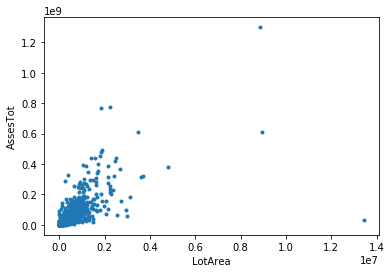

In [303]:
# plotting
plt.plot(data[:,2],data[:,1],'.')
plt.xlabel('LotArea')
plt.ylabel('AssesTot')
plt.show()

In [304]:
# log scale AssessTot
data[:,1] = np.log(1.0*np.hstack(data[:,1]))

In [305]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 10)
    upper_bound = quartile_3 + (iqr * 10)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [306]:
# remove outliers
index = np.zeros(len(data))
for i in range(1,7):
    index[outliers_iqr(data[:,i])] = 1
data = data[np.where(index==0)]

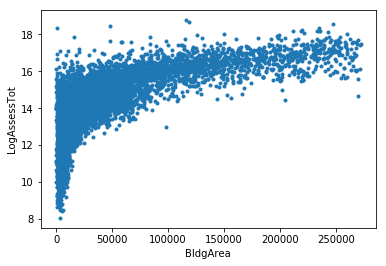

In [307]:
# plotting
plt.plot(np.hstack(data[:,2]),data[:,1],'.')
plt.xlabel('BldgArea')
plt.ylabel('LogAssessTot')
plt.show()

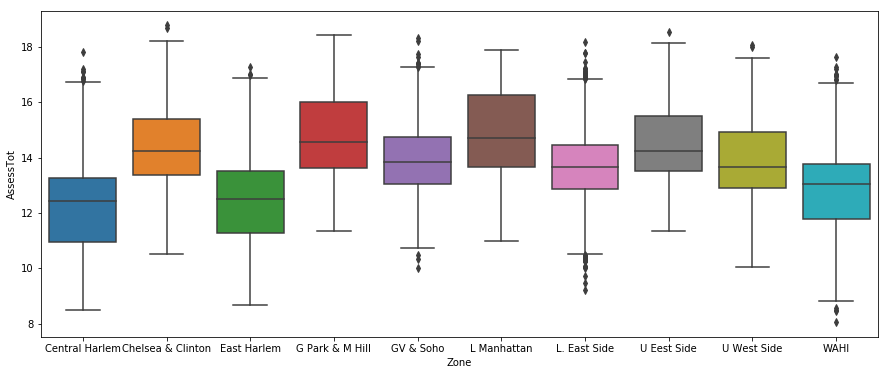

In [308]:
import seaborn as sns
# sns.set(style="ticks")
plt.figure(figsize=(15,6))
plt.xlabel('Zone')
plt.ylabel('AssessTot')
sns.boxplot(y=np.hstack(data[:,1]), x=np.hstack(data[:,33]),width=0.8,order=[u'Central Harlem', u'Chelsea & Clinton', u'East Harlem', u'G Park & M Hill', u'GV & Soho', u'L Manhattan',u'L. East Side', u'U Eest Side', u'U West Side', u'WAHI'])
# sns.boxplot(y=np.hstack(data[:,1]), x=np.hstack(data[:,33]),width=0.8)
plt.show()

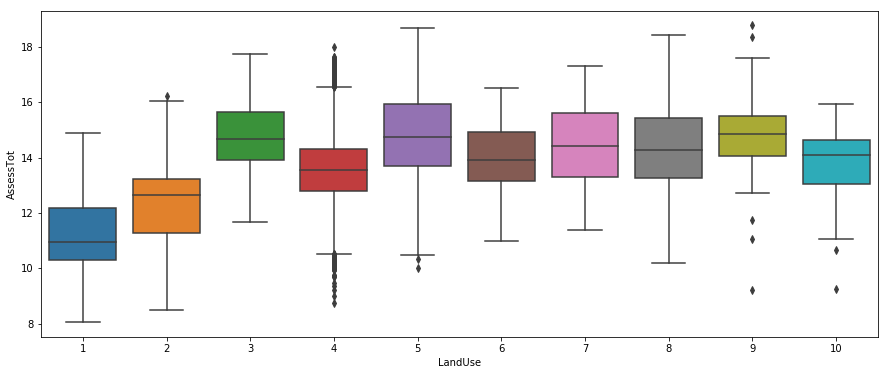

In [309]:
plt.figure(figsize=(15,6))
plt.xlabel('LandUse')
plt.ylabel('AssessTot')
sns.boxplot(y=np.hstack(data[:,1]), x=np.hstack(data[:,34]),width=0.8)
plt.show()

In [310]:
# scaling
data = data[:,1:33].astype(float)
temp = data[:,:6]
temp = (temp - temp.min(axis = 0))/(temp.max(axis=0)-temp.min(axis = 0))
data = np.hstack((temp,data[:,6:]))
# adding offset
data = np.hstack((data,np.ones((len(data),1))))

In [311]:
# partitioning, randomly select 80% samples as traininig set, 20% as test set
n = int(len(data)*0.8)
trainset = random.sample(range(len(data)),n)
testset = [i for i in range(len(data)) if i not in trainset]
X = data[trainset,1:]
Y = data[trainset,0]
X_test = data[testset,1:]
Y_test = data[testset,0]

In [338]:
# l2 loss, no regularizor, python linear regression package
# create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)
# train the model
regr.fit(X,Y)
# test the model
Y_pred = regr.predict(X)
Y_test_pred = regr.predict(X_test)
# the coefficients
np.set_printoptions(precision=4, suppress=True)
print('coefficients:', regr.coef_)
# mean squared error
print('mean_squared_error train: %.4f' % mean_squared_error(Y,Y_pred))
print('mean_squared_error test: %.4f' % mean_squared_error(Y_test,Y_test_pred))

('coefficients:', array([ 0.3196,  0.4075,  0.1161,  0.0552,  0.1188,  0.0255, -0.0307,
        0.0482, -0.0317,  0.0532,  0.0376, -0.0063,  0.04  ,  0.0811,
        0.0494, -0.0091, -0.1128, -0.0106,  0.0617,  0.0397,  0.0713,
        0.0421,  0.0001,  0.056 ,  0.0466,  0.0378,  0.0597,  0.0233,
        0.0519,  0.0458,  0.0511,  0.2318]))
mean_squared_error train: 0.0060
mean_squared_error test: 0.0063


In [339]:
# coefficient plot
def coef_plot(w):
    plt.bar(range(len(w)),w)
    plt.xlabel('predictors')
    plt.ylabel('coefficients')
    plt.title('regression results - coefficients')
    plt.show()

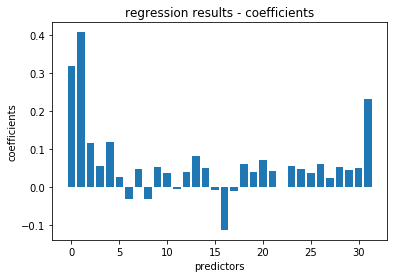

In [340]:
coef_plot(regr.coef_)

In [341]:
# true value, predicted value
def pred_value_plot(Y,Y_pred):
    plt.plot(Y,Y_pred,'.')
    plt.plot(Y,Y)
    plt.xlabel('true value')
    plt.ylabel('predicted value')
    plt.title('predicted value vs true value of test set')
    plt.show()

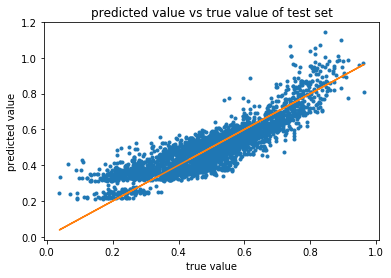

In [342]:
pred_value_plot(Y_test,Y_test_pred)

In [343]:
# residual plot
def residual_plot(Y,Y_pred):
    plt.plot(Y_pred,Y-Y_pred,'.')
    plt.plot([0.2,1.2],[0,0])
    plt.xlabel('fitted value')
    plt.ylabel('residual')
    plt.show()

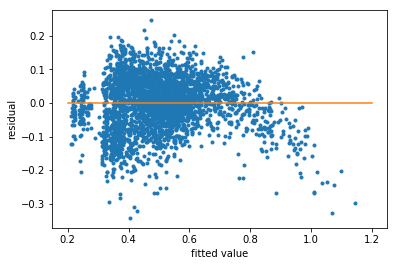

In [344]:
residual_plot(Y_test,Y_test_pred)

In [345]:
# l2 loss, no regularizor, solve to the end
w = np.dot(np.linalg.pinv(X),Y)
Y_test_pred = np.dot(X_test,w)
print('mean_squared_error test: %.4f' % mean_squared_error(Y_test,Y_test_pred))

mean_squared_error test: 0.0063


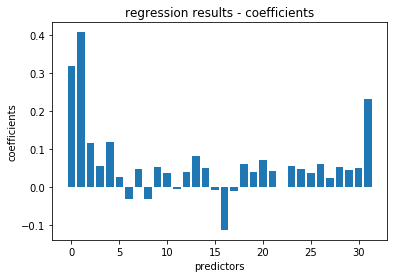

In [346]:
coef_plot(w)

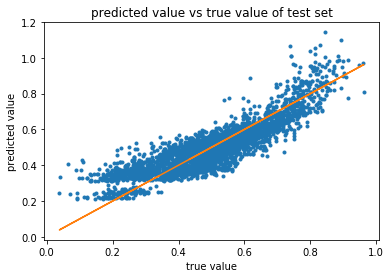

In [347]:
pred_value_plot(Y_test,Y_test_pred)

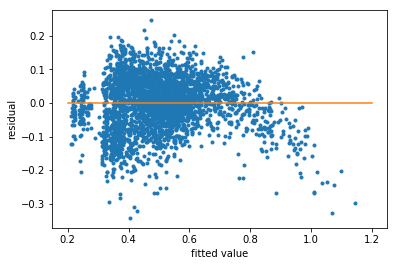

In [348]:
residual_plot(Y_test,Y_test_pred)

In [349]:
# regression with regularization
# objective function of l2 loss smooth regularizor
def l2_smooth(w,X,Y,D):
     return np.square(np.linalg.norm(Y-np.dot(X,w))) + np.square(np.linalg.norm(np.dot(D,w)))
# used to generate the D matrix in smooth regularizor 
def Dmatrix(n):
    r = 0
    t = np.zeros((n*(n-1)/2,n))
    for i in range(n-1):
        for j in range(i+1,n):
            t[r,i] = 1
            t[r,j] = -1
            r += 1
    return t

In [354]:
# stepsize for proximal gradient
U,s,V = np.linalg.svd(X)
step = 1.0/(2.0*np.square(s[0]))
# initial w
w0 = np.zeros(np.shape(X)[1])
# D matrix for smooth regularizor
D = np.zeros((100,np.shape(X)[1]))
D[0:45,6:16] = Dmatrix(10)
D[45:90,16:26] = Dmatrix(10)
D[90:100,26:31] = Dmatrix(5)

In [355]:
def prox_smooth(stepsize,D,z):
    return np.dot(np.linalg.inv(2.0*stepsize*np.dot(D.T,D) + np.eye(np.shape(D)[1])),z)
def proxi_grad_l2_smooth(X,Y,D,maxiters=50,stepsize=step,w=w0):
    obj = []
    for i in range(maxiters):
        g = 2.0*np.dot(X.T,np.dot(X,w)-Y)
        z = w - stepsize*g
        w = prox_smooth(stepsize,D,z)
        obj.append(l2_smooth(w,X,Y,D))
    return obj,w

In [365]:
obj,w = proxi_grad_l2_smooth(X,Y,D)
Y_test_pred = np.dot(X_test,w)
print('mean_squared_error test: %.4f' % mean_squared_error(Y_test,Y_test_pred))

mean_squared_error test: 0.0079


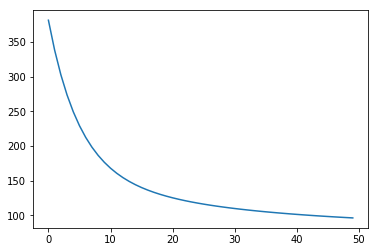

In [357]:
plt.plot(range(50),obj)
plt.show()

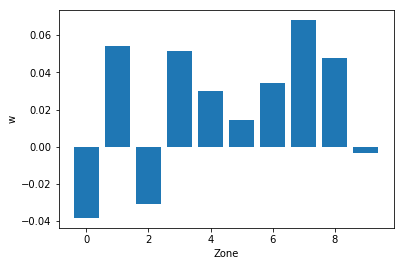

In [358]:
# smoothed coefficients for zones 
plt.bar(range(10),w[6:16])
plt.xlabel('Zone')
plt.ylabel('w')
plt.show()

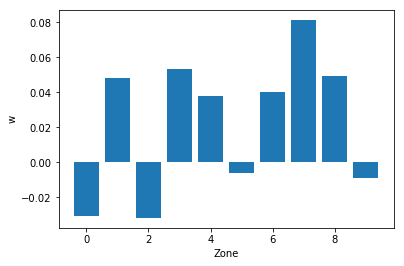

In [359]:
# original coefficients for zones
plt.bar(range(10),regr.coef_[6:16])
plt.xlabel('Zone')
plt.ylabel('w')
plt.show()

From the plot, classify zone into {0,2}{1,3,4,6,8}{7}{5,10}

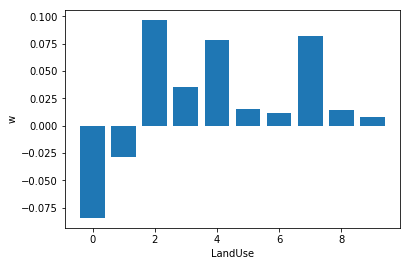

In [360]:
# smoothed coefficients for Landuse 
plt.bar(range(10),w[16:26])
plt.xlabel('LandUse')
plt.ylabel('w')
plt.show()

From the plot, classify landuse into {0}{1}{2,4,7}{3,5,6,8,9}

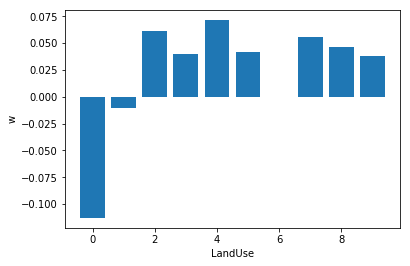

In [361]:
# original coefficients for LandUse
plt.bar(range(10),regr.coef_[16:26])
plt.xlabel('LandUse')
plt.ylabel('w')
plt.show()

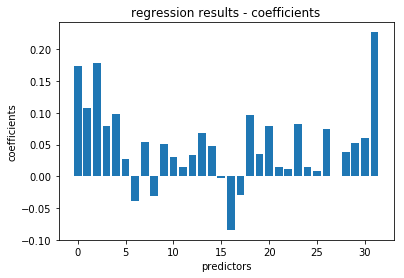

In [362]:
coef_plot(w)

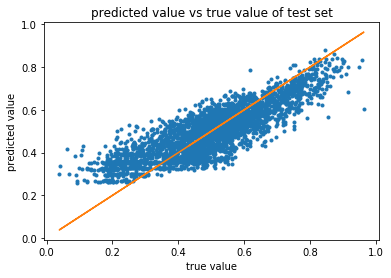

In [364]:
pred_value_plot(Y_test,Y_test_pred)

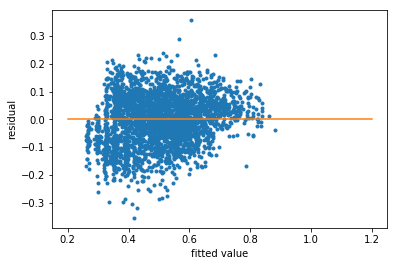

In [366]:
residual_plot(Y_test,Y_test_pred)

Residual plot improved comparing to no regualarizor.